## Get a simple data set object together

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, Dense, MaxPooling2D, Activation, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt


In [2]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-09 07:35:36.980 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 955 files for training.
Using 238 files for validation.
Found 7037 files belonging to 1 classes.
Using 5630 files for training.
Using 1407 files for validation.


## Put the Discrim model together

In [3]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape, batch_size=32)
    
    # First layer doesn't use instance normalization
    x = Conv2D(32, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (32, 128, 128, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (32, 64, 64, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 64, 64, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (32, 64, 64, 64)          0         
                                                     

## Generator model

In [4]:
def DownSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential()
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(Activation('relu'))
    return ret_block


In [5]:
import uuid

def UpSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    ret_block.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(Activation('relu'))
    return ret_block

In [6]:

def Generator(input_shape:tuple, kernel_size:int=3, strides:int=1
              ,filter_line:list[int]=[32,64,128]) -> keras.Model:
    networks_appending = []
    input_block = Input(shape=input_shape)
    ret_block = input_block

    #Create encoder chain
    for filter_choice in filter_line:
        ret_block=DownSampleBlock(filter_choice,3,2)(ret_block)
        networks_appending.append(ret_block)

    #Decoder with residual connections
    for filter_choice, network_append in zip(filter_line[::-1][1:], networks_appending[::-1][1:]):
        ret_block = UpSampleBlock(filter_choice, 3,2)(ret_block)
        ret_block = Concatenate()([ret_block, network_append])
    
    ret_block = Conv2DTranspose(input_shape[-1], kernel_size, strides, padding='same', activation='tanh')(ret_block)

    return Model(input_block, ret_block)



In [7]:
my_generator = Generator((128, 128, 3), strides=2)
my_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 32)           896       ['input_2[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 64)           18496     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 128)          73856     ['sequential_1[0][0]']        
                                                                                              

In [8]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))


## Training loop without generator training (Monet Domain)

In [9]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 5
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)


            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)


Epoch 1/2
Step 1126/1126 - loss: 0.4219
Epoch 1 completed in 300s - avg loss: 2.0922

Epoch 2/2
Step 1126/1126 - loss: 0.1640
Epoch 2 completed in 298s - avg loss: 0.2101


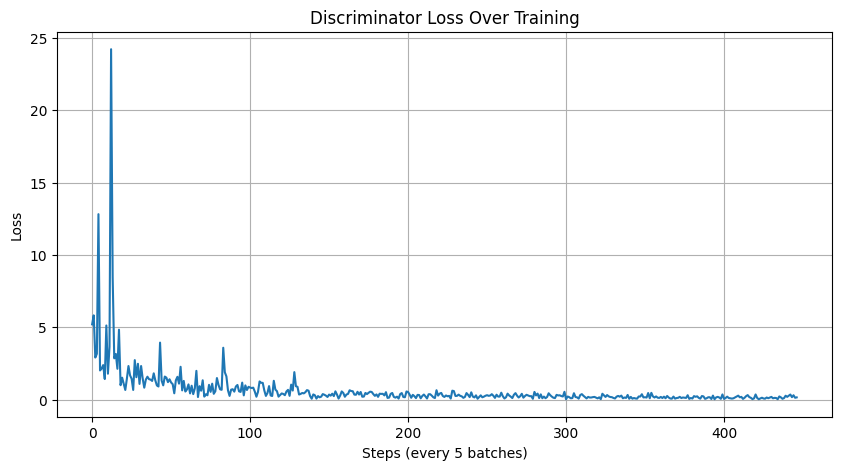

In [10]:
# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses[5:])
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Introducing Generator loss

In [11]:
from keras.losses import binary_crossentropy

In [12]:
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))

In [16]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 5
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

eg_image = next(my_image_ds_train)
eg_output = my_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape(persistent=True) as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)

            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

            monet_generator_loss = generator_loss(fake_monet_output)

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        generator_grads =  tape.gradient(monet_generator_loss, my_generator.trainable_variables)
        gen_optimiser.apply_gradients(zip(generator_grads, my_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            disc_loss = tf.squeeze(loss).numpy()
            gen_loss = tf.squeeze(monet_generator_loss).numpy()
            epoch_losses.append((disc_loss, gen_loss))
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - discriminator loss: {epoch_losses[-1][0]:.4f}, generator loss: {epoch_losses[-1][1]:.4f}", end='')

    epoch_avg_disc_loss = np.mean([l[0] for l in epoch_losses])
    epoch_avg_gen_loss = np.mean([l[1] for l in epoch_losses])
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg discriminator loss: {epoch_avg_disc_loss:.4f}, avg generator loss: {epoch_avg_gen_loss:.4f}")
    all_losses.extend(epoch_losses)



Epoch 1/2
Step 1126/1126 - discriminator loss: 1.0580, generator loss: 0.9846
Epoch 1 completed in 722s - avg discriminator loss: 5.5533, avg generator loss: 0.8468

Epoch 2/2
Step 1126/1126 - discriminator loss: 0.2925, generator loss: 0.9865
Epoch 2 completed in 655s - avg discriminator loss: 0.4176, avg generator loss: 0.9754


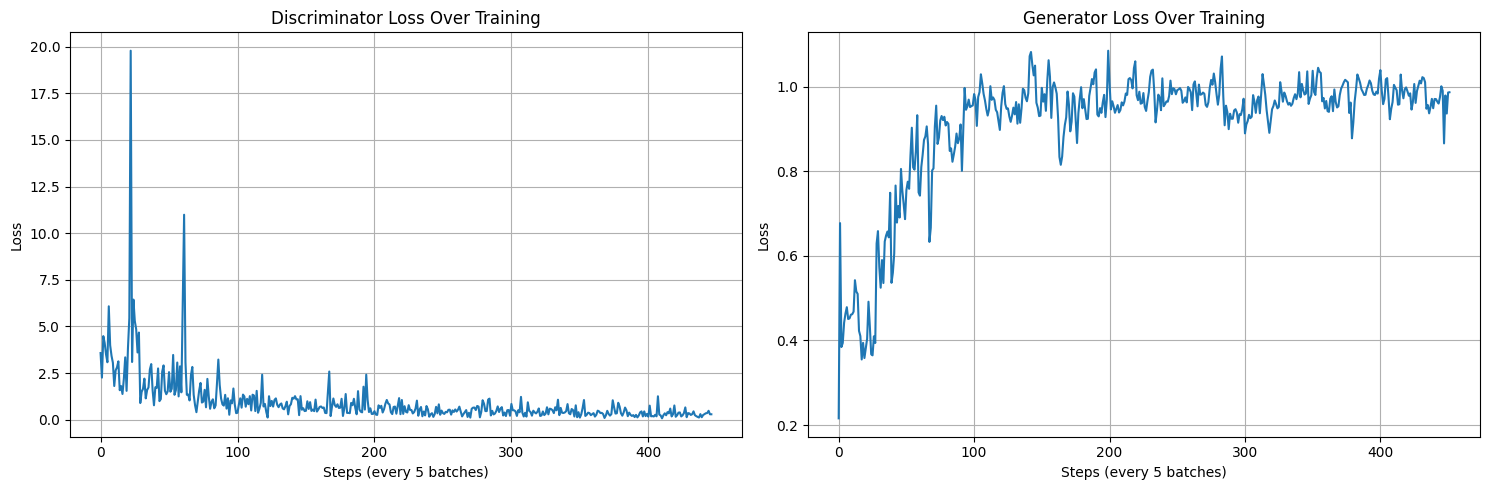

In [18]:

# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
disc_losses = [l[0] for l in all_losses]
plt.plot(disc_losses[5:])
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
gen_losses = [l[1] for l in all_losses]
plt.plot(gen_losses)
plt.title('Generator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

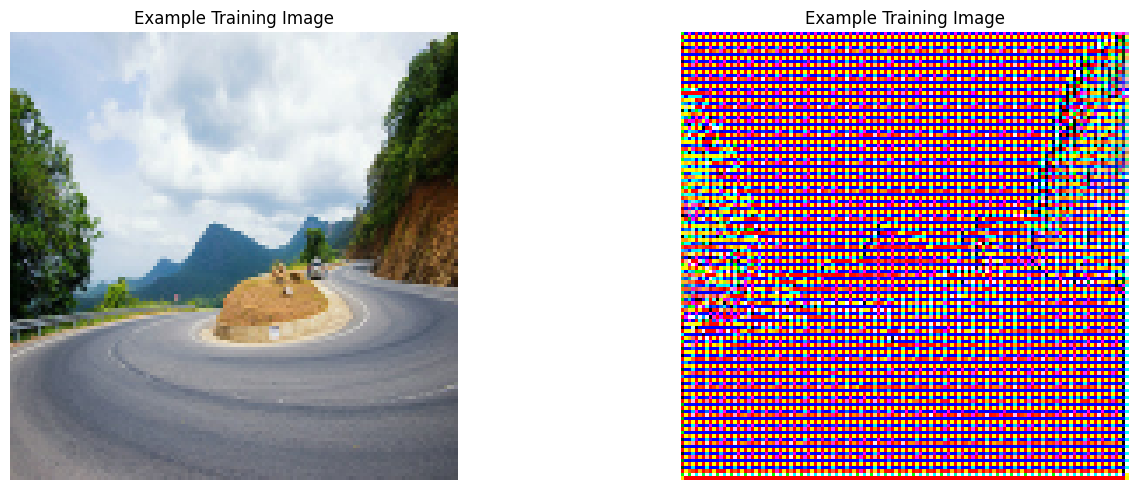

In [26]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] / 255.0)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [27]:
eg_output2 = my_generator(eg_image)

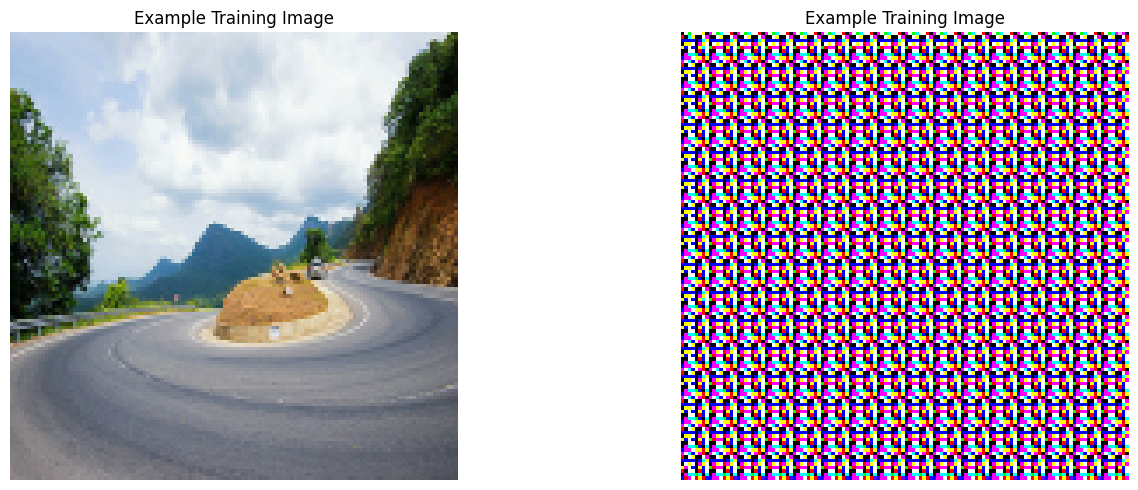

In [28]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] / 255.0)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output2[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


## Adding Alternating trainin

In [42]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 5
EPOCH_LENGTH = DATASET_HEIGHT
DISPLAY_INTERVAL = 10  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

eg_image = next(my_image_ds_train)
eg_output = my_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape(persistent=True) as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)

            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

            monet_generator_loss = generator_loss(fake_monet_output)
        if j % 2 == 0 :
            grads = tape.gradient(loss, my_discriminator.trainable_variables)
            my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))
        else:
            generator_grads =  tape.gradient(monet_generator_loss, my_generator.trainable_variables)
            gen_optimiser.apply_gradients(zip(generator_grads, my_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            disc_loss = tf.squeeze(loss).numpy()
            gen_loss = tf.squeeze(monet_generator_loss).numpy()
            epoch_losses.append((disc_loss, gen_loss))
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - discriminator loss: {epoch_losses[-1][0]:.4f}, generator loss: {epoch_losses[-1][1]:.4f}", end='')

    epoch_avg_disc_loss = np.mean([l[0] for l in epoch_losses])
    epoch_avg_gen_loss = np.mean([l[1] for l in epoch_losses])
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg discriminator loss: {epoch_avg_disc_loss:.4f}, avg generator loss: {epoch_avg_gen_loss:.4f}")
    all_losses.extend(epoch_losses)



Epoch 1/5
Step 5630/5630 - discriminator loss: 0.1620, generator loss: 0.9738
Epoch 1 completed in 1409s - avg discriminator loss: 0.5564, avg generator loss: 0.9329

Epoch 2/5
Step 5630/5630 - discriminator loss: 0.0109, generator loss: 0.9858
Epoch 2 completed in 1622s - avg discriminator loss: 0.0502, avg generator loss: 0.9876

Epoch 3/5
Step 5630/5630 - discriminator loss: 0.0528, generator loss: 0.799525
Epoch 3 completed in 8438s - avg discriminator loss: 0.2885, avg generator loss: 0.9665

Epoch 4/5
Step 5630/5630 - discriminator loss: 0.0160, generator loss: 0.9927
Epoch 4 completed in 1506s - avg discriminator loss: 0.0245, avg generator loss: 0.9658

Epoch 5/5
Step 5630/5630 - discriminator loss: 0.0033, generator loss: 0.9915
Epoch 5 completed in 1070s - avg discriminator loss: 0.0150, avg generator loss: 0.9934


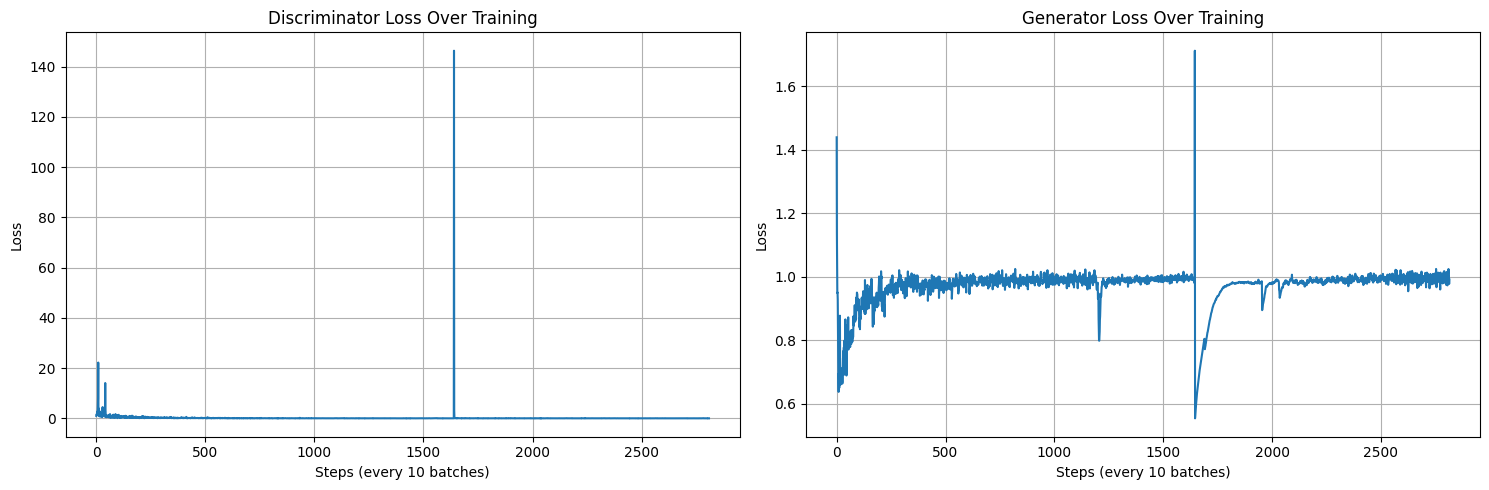

In [43]:

# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
disc_losses = [l[0] for l in all_losses]
plt.plot(disc_losses[5:])
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
gen_losses = [l[1] for l in all_losses]
plt.plot(gen_losses)
plt.title('Generator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

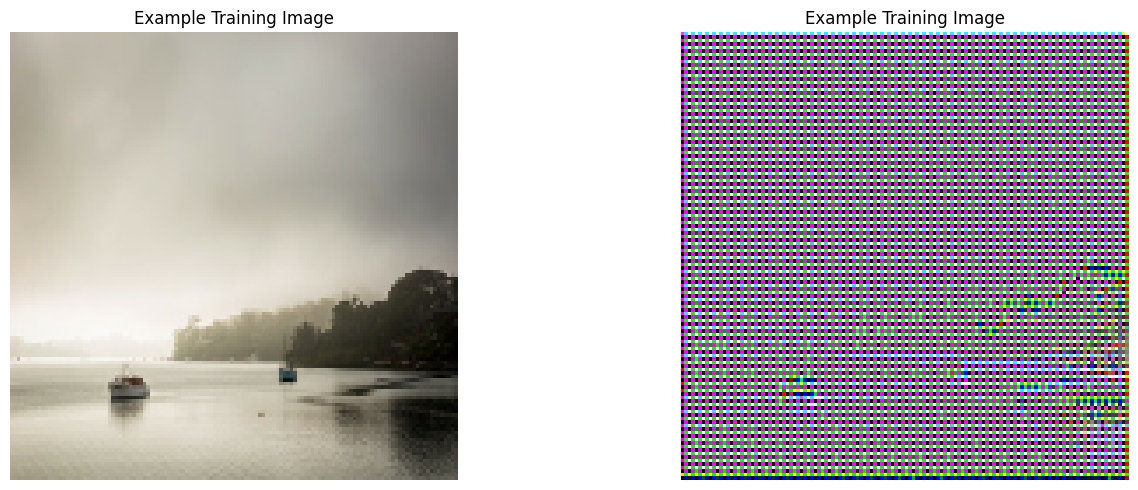

In [44]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] / 255.0)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [45]:
eg_output2 = my_generator(eg_image)

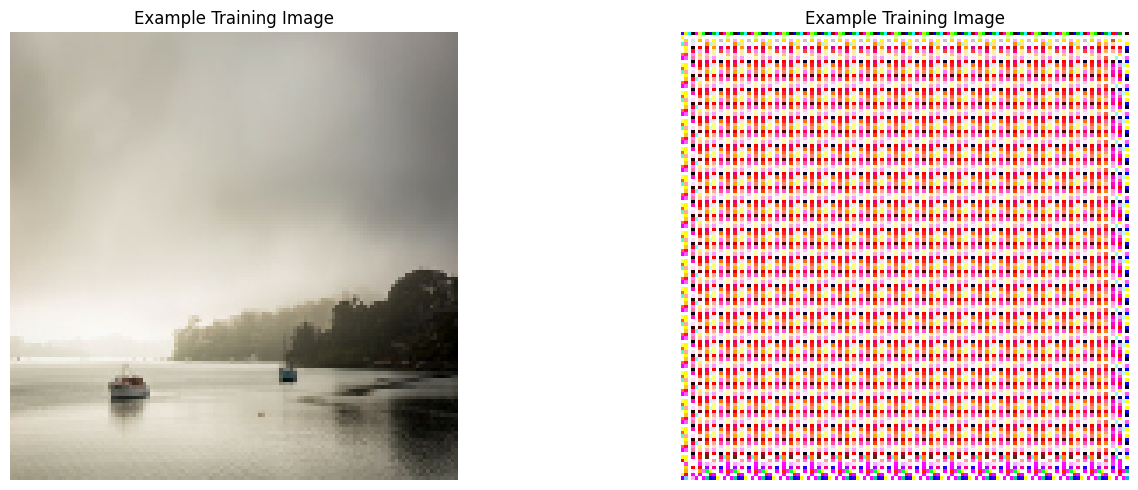

In [46]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] / 255.0)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output2[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [ ]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 3
EPOCH_LENGTH = DATASET_HEIGHT // 3
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3), strides=2)
my_discriminator = build_discriminator()

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            monet_output = my_discriminator(monet_image)
            image_output = my_discriminator(real_image)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), monet_output) +
                my_square_loss(tf.constant(0.0), image_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)

# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()